In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [3]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [4]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [5]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            stat, p = wilcoxon(data[col1], data[col2])
            results.append((col1, col2, stat, p))
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [6]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                score_comparisons[(set1, set2)] = set2
    return score_comparisons

In [7]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [8]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [9]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [15]:
general_biomedical_ranked_df = ranked_df.loc[ranked_df['domain'] == 'general biomedical']
general_biomedical_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
90,ZENODO_4792512,4.000000,2.666667,0.000,0.000000,0.000000,0.000000,2.666667,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,0.000,0.000000,0.0,cancer,general biomedical
91,Mendeley_9mrc3b54g2,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.875,1.500000,0.0,cancer,general biomedical
92,GSE527,0.000000,2.142857,3.750,3.000000,0.000000,0.000000,1.666667,3.750000,3.000000,0.000000,0.000000,1.500000,2.142857,3.750,3.000000,0.0,cancer,general biomedical
93,GSE49052,1.777778,3.200000,2.000,0.000000,0.000000,0.000000,4.000000,2.666667,0.000000,0.000000,0.000000,3.200000,3.200000,1.600,0.000000,0.0,cancer,general biomedical
94,GSE3654,0.000000,0.000000,0.000,0.000000,1.666667,1.875000,0.000000,0.000000,0.000000,1.500000,1.875000,0.000000,0.000000,0.000,0.000000,0.0,cancer,general biomedical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,VIVLI_4ab4915c-0a69-4ec4-a9f6-91587d84cd36,0.000000,0.000000,1.625,1.625000,0.000000,0.000000,1.300000,2.600000,1.857143,1.857143,1.444444,1.625000,2.600000,3.250,3.250000,2.6,myocardial infarction,general biomedical
460,VIVLI_83f50173-5932-43cc-a5a1-0fcf10ab2df5,0.000000,1.500000,2.500,2.142857,0.000000,0.000000,2.142857,3.750000,5.000000,5.000000,3.000000,2.500000,7.500000,7.500,7.500000,7.5,myocardial infarction,general biomedical
461,VIVLI_29044ec7-6219-471a-b34e-5aed6f5a448c,1.625000,2.166667,3.250,2.166667,0.000000,0.000000,2.166667,4.333333,3.250000,2.166667,1.300000,2.600000,4.333333,2.600,2.166667,1.3,myocardial infarction,general biomedical
462,VIVLI_bf209186-d825-4b05-a491-99eb1507c051,0.000000,0.000000,1.500,1.666667,0.000000,0.000000,0.000000,2.500000,3.000000,3.750000,2.500000,1.666667,3.750000,5.000,5.000000,5.0,myocardial infarction,general biomedical


In [16]:
# Calculate scores per search term per combination

general_biomedical_scores_df = compute_scores(general_biomedical_ranked_df, combination_order)
general_biomedical_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,cancer,40.577778,45.148413,47.070635,50.026587,51.784524,52.486111,44.841667,46.593254,50.159921,50.169048,52.486111,44.233730,44.787302,45.804365,46.343254,47.048016
1,myocardial infarction,41.401190,44.036111,44.133730,45.634524,48.825794,51.523810,43.409524,42.283730,42.048810,42.390476,44.750397,43.375000,40.620635,40.728968,40.462302,40.667857
2,rational cancer drug design,51.593254,51.593254,51.843254,52.043254,51.976587,50.115873,51.593254,51.843254,52.043254,52.122619,50.865873,51.593254,51.593254,51.843254,52.043254,51.839683


In [17]:
# Run Wilcoxon test

general_biomedical_wilcoxon_df = perform_wilcoxon_test(general_biomedical_scores_df)
general_biomedical_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,0.0,0.179712
1,original,c2,0.0,0.250000
2,original,c3,0.0,0.250000
3,original,c4,0.0,0.250000
4,original,c5,1.0,0.500000
...,...,...,...,...
115,c12,c14,1.0,0.500000
116,c12,c15,0.0,0.250000
117,c13,c14,2.0,0.750000
118,c13,c15,3.0,1.000000


In [18]:
# Export scores per search term

general_biomedical_scores_df.to_csv('../alternate_test/results/scores_general_biomedical.csv', index = False)

In [19]:
# Drop search term column

general_biomedical_scores_only_df = general_biomedical_scores_df.drop(columns = ['search term'])
general_biomedical_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,40.577778,45.148413,47.070635,50.026587,51.784524,52.486111,44.841667,46.593254,50.159921,50.169048,52.486111,44.233730,44.787302,45.804365,46.343254,47.048016
1,41.401190,44.036111,44.133730,45.634524,48.825794,51.523810,43.409524,42.283730,42.048810,42.390476,44.750397,43.375000,40.620635,40.728968,40.462302,40.667857
2,51.593254,51.593254,51.843254,52.043254,51.976587,50.115873,51.593254,51.843254,52.043254,52.122619,50.865873,51.593254,51.593254,51.843254,52.043254,51.839683


In [20]:
# Compute total scores per combination

general_biomedical_total_scores_df = general_biomedical_scores_only_df.sum()
general_biomedical_total_scores_df

original    133.572222
c1          140.777778
c2          143.047619
c3          147.704365
c4          152.586905
c5          154.125794
c6          139.844444
c7          140.720238
c8          144.251984
c9          144.682143
c10         148.102381
c11         139.201984
c12         137.001190
c13         138.376587
c14         138.848810
c15         139.555556
dtype: float64

In [21]:
# Determine winners by comparing combination scores

winners = compare_scores(general_biomedical_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'c4',
 ('original', 'c5'): 'c5',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'c9',
 ('original', 'c10'): 'c10',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'c14',
 ('original', 'c15'): 'c15',
 ('c1', 'c2'): 'c2',
 ('c1', 'c3'): 'c3',
 ('c1', 'c4'): 'c4',
 ('c1', 'c5'): 'c5',
 ('c1', 'c6'): 'c1',
 ('c1', 'c7'): 'c1',
 ('c1', 'c8'): 'c8',
 ('c1', 'c9'): 'c9',
 ('c1', 'c10'): 'c10',
 ('c1', 'c11'): 'c1',
 ('c1', 'c12'): 'c1',
 ('c1', 'c13'): 'c1',
 ('c1', 'c14'): 'c1',
 ('c1', 'c15'): 'c1',
 ('c2', 'c3'): 'c3',
 ('c2', 'c4'): 'c4',
 ('c2', 'c5'): 'c5',
 ('c2', 'c6'): 'c2',
 ('c2', 'c7'): 'c2',
 ('c2', 'c8'): 'c8',
 ('c2', 'c9'): 'c9',
 ('c2', 'c10'): 'c10',
 ('c2', 'c11'): 'c2',
 ('c2', 'c12'): 'c2',
 ('c2', 'c13'): 'c2',
 ('c2', 'c14'): 'c2',
 ('c2', 'c15'): 'c2',
 (

In [22]:
# Add winners to Wilcoxon test results

general_biomedical_wilcoxon_df['winner'] = general_biomedical_wilcoxon_df.apply(add_winner, axis = 1)
general_biomedical_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,0.0,0.179712,c1
1,original,c2,0.0,0.250000,c2
2,original,c3,0.0,0.250000,c3
3,original,c4,0.0,0.250000,c4
4,original,c5,1.0,0.500000,c5
...,...,...,...,...,...
115,c12,c14,1.0,0.500000,c14
116,c12,c15,0.0,0.250000,c15
117,c13,c14,2.0,0.750000,c14
118,c13,c15,3.0,1.000000,c15


In [23]:
general_biomedical_wilcoxon_df['winner'].value_counts()

c5     15
c4     14
c10    13
c3     12
c9     11
c8     10
c2      9
c1      8
c7      7
c6      6
c15     5
c11     4
c14     3
c13     2
c12     1
Name: winner, dtype: int64

In [25]:
general_biomedical_wilcoxon_df[general_biomedical_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner


In [26]:
# Export Wilcoxon test results

general_biomedical_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_general_biomedical.csv', index = False)

In [27]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

general_biomedical_wilcoxon_df[['set 1', 'set 2', 'p-value']] = general_biomedical_wilcoxon_df.apply(swap_sets, axis = 1)

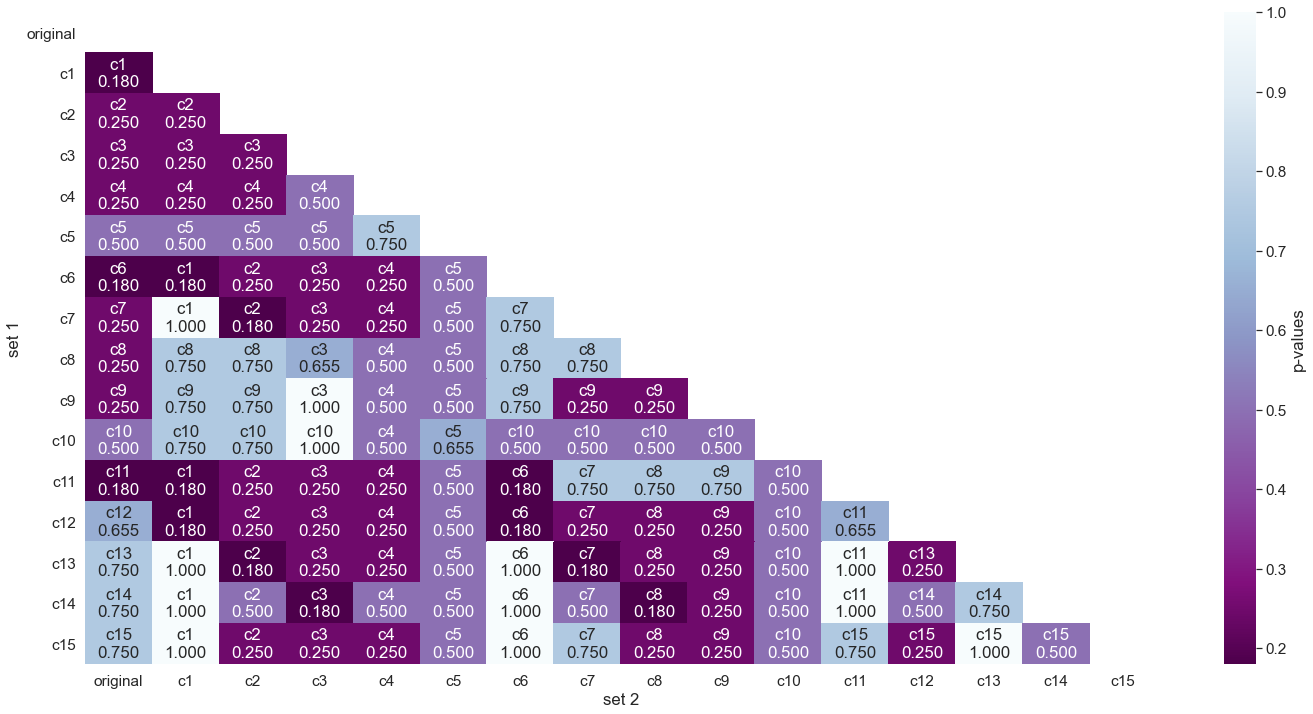

In [28]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(general_biomedical_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_general_biomedical')